<a href="https://colab.research.google.com/github/Laimo64/SAM-Liver/blob/main/UNet_version_small_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customized Segment Anything Model for Medical Image Segmentation
### [[Paper](https://arxiv.org/pdf/2304.13785.pdf)] [[Github](https://github.com/hitachinsk/SAMed)]
---


# Setup environment

In [1]:
!pip install -q gdown==4.6.0 einops==0.6.1 icecream==2.1.3 MedPy==0.4.0 monai==1.1.0 opencv_python==4.5.4.58 SimpleITK==2.2.1 tensorboardX==2.6 ml-collections==0.1.1 onnx==1.13.1 onnxruntime==1.14.1 tensorboardX torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 MB 5.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


# Download codes, pretrained weights and test data

In [2]:
# prepare codes
import os
CODE_DIR = 'samed_codes'
os.makedirs(f'./{CODE_DIR}')
!git clone https://github.com/hitachinsk/SAMed.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')

Cloning into 'samed_codes'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 225 (delta 42), reused 29 (delta 29), pack-reused 167 (from 1)
Receiving objects: 100% (225/225), 636.92 KiB | 21.96 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [3]:
# !gdown --fuzzy https://drive.google.com/file/d/18KVLU4y0BPoRqtHnhsE3KbTQb2BEUXTz/view?usp=sharing
!gdown --fuzzy https://drive.google.com/file/d/1JyTYDCkv3RGUnkE--l-Kf9v5PLOCI3k1/view?usp=drive_link  #L3D_dataset

Downloading...
From (original): https://drive.google.com/uc?id=1JyTYDCkv3RGUnkE--l-Kf9v5PLOCI3k1
From (redirected): https://drive.google.com/uc?id=1JyTYDCkv3RGUnkE--l-Kf9v5PLOCI3k1&confirm=t&uuid=ec3a6d53-50f6-4cde-893c-5f1c5a65a176
To: /content/samed_codes/L3D_Dataset.zip
100% 3.64G/3.64G [01:14<00:00, 48.7MB/s]


In [4]:
%cd /content/samed_codes
#dataset
import zipfile
with zipfile.ZipFile('L3D_Dataset.zip', 'r') as zip_ref:
# with zipfile.ZipFile('test_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()
#weights
!gdown https://drive.google.com/uc?id=1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr #'epoch_159.pth'
!gdown https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg #'sam_vit_b_01ec64.pth'

/content
Downloading...
From: https://drive.google.com/uc?id=1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr
To: /content/samed_codes/epoch_159.pth
100% 19.7M/19.7M [00:00<00:00, 124MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg
From (redirected): https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg&confirm=t&uuid=6b3340e6-7ffa-4e7a-90fe-c7b3af2e6dcb
To: /content/samed_codes/sam_vit_b_01ec64.pth
100% 375M/375M [00:09<00:00, 39.6MB/s]


Dataloader:

/content/samed_codes
[0 1 2 3]


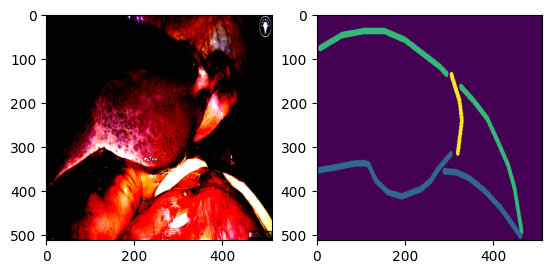

In [3]:
%cd /content/samed_codes
import os
import cv2
import json
import random
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as iio
from torchvision.transforms import InterpolationMode
from scipy import ndimage
from scipy.ndimage import zoom
from glob import glob
from einops import repeat

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def random_rot_flip(image, label):
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    return image, label

def random_rotate(image, label):
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label

class SegmentationDataset(Dataset):
    def __init__(self, root='/content/samed_codes/L3D_Dataset/Train', low_res=None, transform_img=None, transform_mask=None, istrain=False):
        self.img_path_all = glob(root + '/images/*.jpg')  # Update the path and pattern
        self.mask_path_all = glob(root + '/masks_gt/*.png')  # Update the path and pattern
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.istrain = istrain
        self.low_res = low_res

        self.brightness = 0.1
        self.contrast = 0.1
        self.saturation = 0.1
        self.hue = 0.1
        self.color_aug = transforms.ColorJitter(self.brightness, self.contrast, self.saturation, self.hue)

    def __len__(self):
        return len(self.img_path_all)

    def __getitem__(self, idx):
        img_path = self.img_path_all[idx]
        mask_path = self.mask_path_all[idx]
        # print(f"Found {len(self.img_path_all)} images and {len(self.mask_path_all)} masks")

        # Open image and mask
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L') #29(3), 76(1), 150 (2)
        mask = np.array(mask)
        # class mapping
        mask[mask==0] = 0   #background
        mask[mask==76] = 1  #red
        mask[mask==150] = 2 #green
        mask[mask==29] = 3 #blue
        mask = Image.fromarray(mask)
        # Apply transformations if provided
        if self.istrain:
            hflip = random.random() < 0.5
            flip_container = random.choice([Image.FLIP_LEFT_RIGHT, Image.FLIP_TOP_BOTTOM])
            if hflip:
                image = self.color_aug(image)
                image = image.transpose(flip_container)
                mask = mask.transpose(flip_container)
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)  # Convert first channel of mask to Image format
        # image = transforms.ToTensor()(image)  # **Converting image to tensor**
        mask = torch.from_numpy(np.array(mask)).long()
        sample = {'image': image, 'mask': mask}

        if self.low_res:
            low_res_label = zoom(mask, (self.low_res/mask.shape[0], self.low_res/mask.shape[1]), order=0)
            sample = {'image': image, 'mask': mask, 'low_res_label': low_res_label}

        return sample

transform_img = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])

transform_mask = transforms.Compose([
    transforms.Resize((512, 512), interpolation=InterpolationMode.NEAREST),
    # transforms.ToTensor(),
    ])
ds = SegmentationDataset(transform_img=transform_img, transform_mask=transform_mask, istrain=True)
for sample in ds:
    print(np.unique(sample['mask']))  # Check unique values in the mask (class IDs)
    plt.subplot(121); plt.imshow(sample['image'].permute(1, 2, 0))  # Rearrange image channels for display
    plt.subplot(122); plt.imshow(sample['mask'])  # Display the mask
    break



Visualize & Save Check point

In [4]:
def save_checkpoint(net, optimizer, epoch, best_loss, best_epoch, best_result, checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'best_loss': best_loss,
        'best_epoch': best_epoch,
        # 'epoch_since_improvement': epoch_since_improvement,
        'best_result': best_result,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at '{checkpoint_path}' (Epoch {epoch}, Best Loss {best_loss}, Best Epoch {best_epoch})")


def load_checkpoint(model, optimizer, filename, device='cpu'):
    if os.path.isfile(filename):  # 檢查檔案是否存在
        print(f"=> Loading checkpoint from '{filename}'")
        checkpoint = torch.load(filename, map_location=device)

        # 載入模型和優化器的狀態
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # 獲取其他保存的狀態
        start_epoch = checkpoint.get('epoch', 0) + 1
        best_loss = checkpoint.get('best_loss', float('inf'))
        best_epoch = checkpoint.get('best_epoch', 0)
        best_result = checkpoint.get('best_result', None)

        print(f"=> Loaded checkpoint (Epoch {checkpoint.get('epoch', 'N/A')})")
        return start_epoch, best_loss, best_epoch, best_result
    else:
        print(f"=> No checkpoint found at '{filename}'")
        # 返回初始狀態，確保不會中斷訓練流程
        return 1, float('inf'), 0, None



In [5]:
def plot_inference(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()  # Disable dropout and batch normalization
    num_samples_to_plot = 3  # Number of images to visualize

    fig, axs = plt.subplots(num_samples_to_plot, 3, figsize=(12, num_samples_to_plot * 4),
                            subplot_kw=dict(xticks=[], yticks=[]))
    fig.suptitle("Input Image | Predicted Mask | Ground Truth", fontsize=16)

    with torch.no_grad():  # Disable gradient calculation
        for i_batch, sampled_batch in enumerate(testloader):
            if i_batch >= num_samples_to_plot:
                break

            try:
                image_batch, label_batch, low_res_label_batch = (
                    sampled_batch['image'],
                    sampled_batch['mask'],
                    sampled_batch['low_res_label']
                )
                image_batch = image_batch.to(device, dtype=torch.float32)
                label_batch = label_batch.to(device, dtype=torch.long)
            except Exception as e:
                print(f"Error loading data for batch {i_batch + 1}: {e}")
                continue

            # Call the model with only the image_batch
            outputs = model(image_batch)  # Removed multimask_output and args.img_size
            logits = outputs  # Assuming model directly outputs logits
            pred_seg = torch.argmax(logits, dim=1)

            input_image = image_batch[0].cpu().numpy().transpose(1, 2, 0)
            pred_mask = pred_seg[0].cpu().numpy()
            true_mask = label_batch[0].cpu().numpy()

            input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())

            axs[i_batch, 0].imshow(input_image)
            axs[i_batch, 0].set_title("Input Image")

            axs[i_batch, 1].imshow(pred_mask, cmap="jet", interpolation="none")
            axs[i_batch, 1].set_title("Predicted Mask")

            axs[i_batch, 2].imshow(true_mask, cmap="jet", interpolation="none")
            axs[i_batch, 2].set_title("Ground Truth Mask")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


UNet Training

In [5]:
pip install monai medpy icecream

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━

In [8]:
%cd /content/samed_codes
import os
import sys
from tqdm import tqdm
import logging
import numpy as np
import argparse
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from importlib import import_module
from segment_anything import sam_model_registry
from datasets.dataset_synapse import Synapse_dataset
from icecream import ic
from medpy import metric
from scipy.ndimage import zoom
import torch.nn as nn
import SimpleITK as sitk
import torch.nn.functional as F
import imageio
from einops import repeat

from torch.nn.modules.loss import CrossEntropyLoss
from utils import DiceLoss
import torch.optim as optim
import monai
from torchvision.transforms import InterpolationMode
from torch.nn.functional import one_hot

def seed_everything(seed=42):
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def calc_loss(outputs, label_batch, ce_loss, dice_loss, dice_weight:float=0.8):
    loss_ce = ce_loss(outputs, label_batch[:].long())
    loss_dice = dice_loss(outputs, label_batch, softmax=True)
    loss = (1 - dice_weight) * loss_ce + dice_weight * loss_dice
    return loss, loss_ce, loss_dice


def training_per_epoch(model, trainloader, optimizer, iter_num, ce_loss, dice_loss, multimask_output=True, args=None):
    model.train()
    loss_all = []
    for i_batch, sampled_batch in enumerate(trainloader):
        image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['mask'], sampled_batch['low_res_label']
        image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
        outputs = model(image_batch)
        # print('out:',outputs.shape)
        loss, loss_ce, loss_dice = calc_loss(outputs, label_batch, ce_loss, dice_loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_all.append(loss.item())
        if args.warmup and iter_num < args.warmup_period:
            lr_ = args.base_lr * ((iter_num + 1) / args.warmup_period)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_
        else:
            if args.warmup:
                shift_iter = iter_num - args.warmup_period
                assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
            else:
                shift_iter = iter_num
            lr_ = args.base_lr * (1.0 - shift_iter / args.max_iterations) ** 0.9  # learning rate adjustment depends on the max iterations
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_

        iter_num = iter_num + 1

    return np.mean(loss_all)

def test_per_epoch(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()
    loss_per_epoch = []
    dice_per_class = np.zeros(args.num_classes)  # save dice per class
    count_per_class = np.zeros(args.num_classes)

    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, _ = sampled_batch['image'], sampled_batch['mask'], sampled_batch['low_res_label']
            image_batch, label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long)

            outputs = model(image_batch)
            loss, loss_ce, loss_dice = calc_loss(outputs, label_batch, ce_loss, dice_loss)
            loss_per_epoch.append(loss.item())

            # calaulate dice for each class
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            for cls in range(args.num_classes):
                mask_pred = (preds == cls).float()
                mask_true = (label_batch == cls).float()
                intersection = (mask_pred * mask_true).sum()
                union = mask_pred.sum() + mask_true.sum()
                if union > 0:
                    dice_cls = (2. * intersection) / union
                    dice_per_class[cls] += dice_cls.item()
                    count_per_class[cls] += 1

    # calculate average dice
    avg_dice_per_class = dice_per_class / np.maximum(count_per_class, 1)

    return np.mean(loss_per_epoch), avg_dice_per_class


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    #####
    parser.add_argument('--volume_path', type=str, default='/content/samed_codes/L3D_Dataset')
    parser.add_argument('--data_path', type=str, default='L3D_Dataset')
    #####
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=3)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='results')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=6, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    parser.add_argument('--base_lr', type=float, default=0.0005, help='segmentation network learning rate')
    parser.add_argument('--batch_size', type=int, default=16, help='batch_size per gpu')
    parser.add_argument('--warmup', type=bool, default=True, help='If activated, warp up the learning from a lower lr to the base_lr')
    parser.add_argument('--warmup_period', type=int, default=250, help='Warp up iterations, only valid whrn warmup is activated')
    parser.add_argument('--AdamW', type=bool, default=True, help='If activated, use AdamW to finetune SAM model')
    parser.add_argument('--max_epochs', type=int, default=50, help='maximum epoch number to train')
    parser.add_argument('--max_iterations', type=int, default=30000, help='maximum epoch number to train')


    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    args.output_dir = 'results'
    os.makedirs(args.output_dir, exist_ok = True)

    ############# ask!!
    net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                         in_channels=3, out_channels=1, init_features=32, pretrained=True)
    net.conv = nn.Conv2d(32, args.num_classes + 1, kernel_size=1, stride=1)
    # net.conv = nn.Conv2d(32, args.num_classes, kernel_size=1, stride=1)
    net.to(device)
    ############
    transform_img = transforms.Compose([
      transforms.Resize((512, 512)),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
          )
      ])
    transform_mask = transforms.Compose([
        transforms.Resize((512, 512), interpolation=InterpolationMode.NEAREST),
        # transforms.ToTensor(),
        ])

    multimask_output = True if args.num_classes > 1 else False
    train_dataset = SegmentationDataset(root=(args.data_path+'/Train'), low_res=128, transform_img=transform_img, transform_mask=transform_mask, istrain=True)
    test_dataset = SegmentationDataset(root=(args.data_path+'/Test'), low_res=128, transform_img=transform_img, transform_mask=transform_mask)
    trainloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
    print('Training on:', device, 'train sample size:', len(train_dataset), 'test sample size:', len(test_dataset), 'batch:', args.batch_size)

    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(args.num_classes + 1)
    # dice_loss = DiceLoss(args.num_classes )
    b_lr = args.base_lr / args.warmup_period
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=b_lr, betas=(0.9, 0.999), weight_decay=0.1)
    iter_num = 0

    best_epoch, best_loss = 0.0, np.inf

    ######### load chechpoint
    checkpoint_path = '/content/samed_codes/checkpoint.pth'
    start_epoch, best_loss, best_epoch, best_result = load_checkpoint(net, optimizer, 'checkpoint.pth')
    # start_epoch, best_loss, best_epoch, epoch_since_improvement, best_result = load_checkpoint(net, optimizer, 'checkpoint.pth')

    if start_epoch == 1 and isinstance(best_loss, list) and best_loss == [0, 0]:
        print("No checkpoint loaded; starting training from scratch.")
        best_loss = np.inf
    else:
        print(f"Resuming training from epoch {start_epoch} with best loss {best_loss}, best epoch {best_epoch}.")
    ########
    print ('Test data numbers: ', len(train_dataset), 'Train data numbers: ', len(test_dataset))

    for epoch in range(start_epoch, args.max_epochs):
        loss_training = training_per_epoch(net, trainloader, optimizer, iter_num, ce_loss, dice_loss, multimask_output=multimask_output, args=args)
        loss_testing, dice_per_class = test_per_epoch(net, testloader, ce_loss, dice_loss,multimask_output=True, args=args)

        ##### save checkpoint
        save_checkpoint(net, optimizer, epoch, best_loss, best_epoch, best_result, checkpoint_path)
        #####

        if loss_testing < best_loss:
            best_loss = loss_testing
            best_epoch = epoch
            torch.save(net.state_dict(), os.path.join(args.output_dir, 'model_best.pt'))
            # net.save_lora_parameters(os.path.join(args.output_dir, 'model_best.pt'))

        print(f'--- Epoch {epoch}/{args.max_epochs}: Training loss = {loss_training:.4f}, Testing: [loss = {loss_testing:.4f}]')
        for cls in range(args.num_classes+1):
          if dice_per_class[cls] is not None:
              print(f'    Dice for class {cls}: {dice_per_class[cls]:.4f}')
        # Visualize
        if epoch % 5 ==0:
          plot_inference(net, testloader, ce_loss, dice_loss, multimask_output=True, args=args)

if __name__ == '__main__':
    seed_everything()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # safe checkpoint
    checkpoint_path = 'checkpoints'

    main()



/content/samed_codes
Training on: cuda train sample size: 921 test sample size: 109 batch: 16
=> Loading checkpoint from 'checkpoint.pth'


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` or the `torch.serialization.safe_globals([scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

Inference: My Dice Metrics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import monai

def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    replace_indices = np.vstack((
        ground_truth.flatten(),
        prediction.flatten())
    ).T
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),
        range=[(0, nr_labels), (0, nr_labels)]
    )
    confusion_matrix = confusion_matrix.astype(np.uint32)
    return confusion_matrix

def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[index, index]
        false_positives = confusion_matrix[:, index].sum() - true_positives
        false_negatives = confusion_matrix[index, :].sum() - true_positives
        denom = 2 * true_positives + false_positives + false_negatives
        if denom == 0:
            dice = 0
        else:
            dice = 2 * float(true_positives) / denom
        dices.append(dice)
    return dices

def test_per_epoch(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()
    fig, axs = plt.subplots(len(testloader), 3, figsize=(1*3, len(testloader)*1), subplot_kw=dict(xticks=[],yticks=[]))
    loss_per_epoch, dice_per_epoch = [], []
    num_classes = args.num_classes + 1
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    class_wise_dice = []
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
            image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
            logits = model(image_batch)
            prob = F.softmax(logits, dim=1)
            pred_seg = torch.argmax(prob, dim=1)
            confusion_matrix += calculate_confusion_matrix_from_arrays(pred_seg.cpu(), label_batch.cpu(), num_classes)
            loss, loss_ce, loss_dice = calc_loss(logits, label_batch, ce_loss, dice_loss)
            loss_per_epoch.append(loss.item())
            dice_per_epoch.append(1-loss_dice.item())
            loss_dice = dice_loss(logits, label_batch, softmax=True)
            img_num = 0
            axs[i_batch, 0].imshow(image_batch[img_num, 0].cpu().numpy(), cmap='gray')
            axs[i_batch, 1].imshow(label_batch[img_num].cpu().numpy(), cmap='gray')
            axs[i_batch, 2].imshow(pred_seg[img_num].cpu().numpy(), cmap='gray')
            metric_list = []
            pred_seg, label_batch = pred_seg.cpu().detach().numpy(), label_batch.cpu().detach().numpy()

        confusion_matrix = confusion_matrix[1:, 1:]  # exclude background
        dices_per_class = {'dice_cls:{}'.format(cls + 1): dice
                    for cls, dice in enumerate(calculate_dice(confusion_matrix))}

    return np.mean(loss_per_epoch), np.mean(dice_per_epoch), dices_per_class



if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    ##################
    parser.add_argument('--volume_path', type=str, default='/content/samed_codes/test_dataset')
    parser.add_argument('--data_path', type=str, default='test_dataset')
    ##################
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=3)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='results')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=4, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    parser.add_argument('--base_lr', type=float, default=0.005, help='segmentation network learning rate')
    parser.add_argument('--batch_size', type=int, default=12, help='batch_size per gpu')
    parser.add_argument('--warmup', type=bool, default=True, help='If activated, warp up the learning from a lower lr to the base_lr')
    parser.add_argument('--warmup_period', type=int, default=250, help='Warp up iterations, only valid whrn warmup is activated')
    parser.add_argument('--AdamW', type=bool, default=True, help='If activated, use AdamW to finetune SAM model')
    parser.add_argument('--max_epochs', type=int, default=10, help='maximum epoch number to train')
    parser.add_argument('--max_iterations', type=int, default=30000, help='maximum epoch number to train')


    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    args.ckpt = 'results/model_best.pt'
    ckpt = torch.load(args.ckpt)
    print("ckpt: ",ckpt.keys())  # 查看權重包含哪些鍵值

    print("num_classes=", args.num_classes)
    net = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=3,
        out_channels=args.num_classes + 1,

        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                         in_channels=3, out_channels=1, init_features=32, pretrained=True)
    print("net: ",net.state_dict().keys())  # 檢查目前模型的層名稱


    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(args.num_classes + 1)

    net.load_state_dict(torch.load(args.ckpt))
    test_dataset = SegmentationDataset(root=(args.data_path+'/Test'), low_res=128, transform_img=transform_img, transform_mask=transform_mask)
    testloader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=2)
    test_loss, overall_dice, dices_per_class = test_per_epoch(net, testloader, ce_loss, dice_loss, multimask_output=True, args=args)
    dices_per_class_list = np.array(list(dices_per_class.values()))
    print('Class Wise Dice:', dices_per_class)
    print('Overall Dice:', np.mean(dices_per_class_list))

ckpt:  odict_keys(['encoder1.enc1conv1.weight', 'encoder1.enc1norm1.weight', 'encoder1.enc1norm1.bias', 'encoder1.enc1norm1.running_mean', 'encoder1.enc1norm1.running_var', 'encoder1.enc1norm1.num_batches_tracked', 'encoder1.enc1conv2.weight', 'encoder1.enc1norm2.weight', 'encoder1.enc1norm2.bias', 'encoder1.enc1norm2.running_mean', 'encoder1.enc1norm2.running_var', 'encoder1.enc1norm2.num_batches_tracked', 'encoder2.enc2conv1.weight', 'encoder2.enc2norm1.weight', 'encoder2.enc2norm1.bias', 'encoder2.enc2norm1.running_mean', 'encoder2.enc2norm1.running_var', 'encoder2.enc2norm1.num_batches_tracked', 'encoder2.enc2conv2.weight', 'encoder2.enc2norm2.weight', 'encoder2.enc2norm2.bias', 'encoder2.enc2norm2.running_mean', 'encoder2.enc2norm2.running_var', 'encoder2.enc2norm2.num_batches_tracked', 'encoder3.enc3conv1.weight', 'encoder3.enc3norm1.weight', 'encoder3.enc3norm1.bias', 'encoder3.enc3norm1.running_mean', 'encoder3.enc3norm1.running_var', 'encoder3.enc3norm1.num_batches_tracked', '

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


RuntimeError: Error(s) in loading state_dict for UNet:
	size mismatch for conv.weight: copying a param with shape torch.Size([4, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 32, 1, 1]).
	size mismatch for conv.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([1]).